
**Import libraries**

In [13]:
#Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output


**Load dataset**

In [14]:
file_path = '/content/Football.csv'
data = pd.read_csv(file_path)

<ipython-input-14-b603f4b56f35>:2: DtypeWarning: Columns (4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


**Explore the dataset**

In [15]:
print("Dataset shape (rows, columns):", data.shape)

print("First 5 rows:")
display(data.head())

print("Missing values per column:")
print(data.isnull().sum())

Dataset shape (rows, columns): (95384, 91)
First 5 rows:


,Country,League,home_team,away_team,home_score,away_score,season_year,Date_day,Date_hour,first_half,...,Distance_Covered_(km)_Home,Distance_Covered_(km)_Host,Clearances_Completed_Home,Clearances_Completed_Host,Pass_Success_per_Home,Pass_Success_per_Host,referee,venue,capacity,attendance
0,Germany,Bundesliga,B. Monchengladbach,Werder Bremen,4,1,2024/2025,3.11,19:30,3 - 0,...,NaN,NaN,NaN,NaN,NaN,NaN,Dankert B. (Ger),Borussia-Park (Mönchengladbach),54 042,54 042
1,Germany,Bundesliga,Freiburg,Mainz,0,0,2024/2025,3.11,17:30,0 - 0,...,NaN,NaN,NaN,NaN,NaN,NaN,Brand B. (Ger),Europa-Park Stadion (Freiburg),34 700,34 400
2,Germany,Bundesliga,Dortmund,RB Leipzig,2,1,2024/2025,2.11,20:30,1 - 1,...,NaN,NaN,NaN,NaN,NaN,NaN,Stieler T. (Ger),Signal Iduna Park (Dortmund),81 365,81 365
3,Germany,Bundesliga,Bayern Munich,Union Berlin,3,0,2024/2025,2.11,17:30,2 - 0,...,NaN,NaN,NaN,NaN,NaN,NaN,Jollenbeck M. (Ger),Allianz Arena (Munich),75 024,75 000
4,Germany,Bundesliga,Eintracht Frankfurt,Bochum,7,2,2024/2025,2.11,17:30,4 - 1,...,NaN,NaN,NaN,NaN,NaN,NaN,Schlager D. (Ger),Deutsche Bank Park (Frankfurt),58 000,58 000


Missing values per column:
Country                      0
League                       0
home_team                    0
away_team                    0
home_score                   0
                         ...  
Pass_Success_per_Host    95371
referee                  52476
venue                    25828
capacity                 25833
attendance               64590
Length: 91, dtype: int64


**Select features**

In [16]:
# We'll use 10 features from the first half of the match

columns_needed = [
    'Shots_on_Goal_Home', 'Shots_on_Goal_Host',
    'Ball_Possession_Home', 'Ball_Possession_Host',
    'Fouls_Home', 'Fouls_Host',
    'Corner_Kicks_Home', 'Corner_Kicks_Host',
    'home_score', 'away_score'
]

# Create a new DataFrame with selected features

df_model = data[columns_needed].copy()

**Preprocessing**

In [17]:
# Convert possession values like "58%" to numeric
def convert_percentage(val):
    if isinstance(val, str) and '%' in val:
        return float(val.replace('%', '').strip())
    try:
        return float(val)
    except:
        return np.nan

df_model['Ball_Possession_Home'] = df_model['Ball_Possession_Home'].apply(convert_percentage)
df_model['Ball_Possession_Host'] = df_model['Ball_Possession_Host'].apply(convert_percentage)
df_model['home_score'] = pd.to_numeric(df_model['home_score'], errors='coerce')
df_model['away_score'] = pd.to_numeric(df_model['away_score'], errors='coerce')
df_model.dropna(inplace=True)

**Create target column**

In [18]:

# Generate 'SecondHalfControl' label
def determine_control_advanced(row):
    home_points = 0
    away_points = 0
    if row['Shots_on_Goal_Home'] > row['Shots_on_Goal_Host']:
        home_points += 1
    elif row['Shots_on_Goal_Host'] > row['Shots_on_Goal_Home']:
        away_points += 1
    if row['Ball_Possession_Home'] > row['Ball_Possession_Host']:
        home_points += 1
    elif row['Ball_Possession_Host'] > row['Ball_Possession_Home']:
        away_points += 1
    if row['Corner_Kicks_Home'] > row['Corner_Kicks_Host']:
        home_points += 1
    elif row['Corner_Kicks_Host'] > row['Corner_Kicks_Home']:
        away_points += 1
    return 1 if home_points > away_points else 0

df_model['SecondHalfControl'] = df_model.apply(determine_control_advanced, axis=1)


**Prepare for training**

In [19]:
X = df_model[columns_needed]
y = df_model['SecondHalfControl']

# split the data 80% training , 2-% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Visualize data distributions**

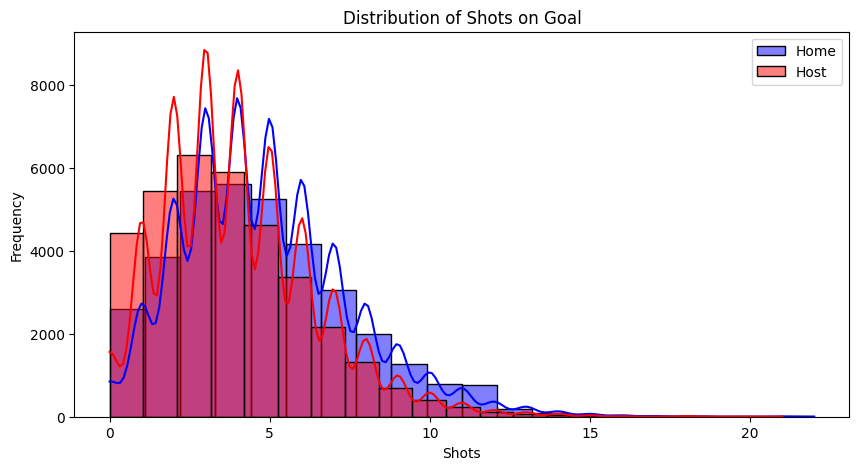

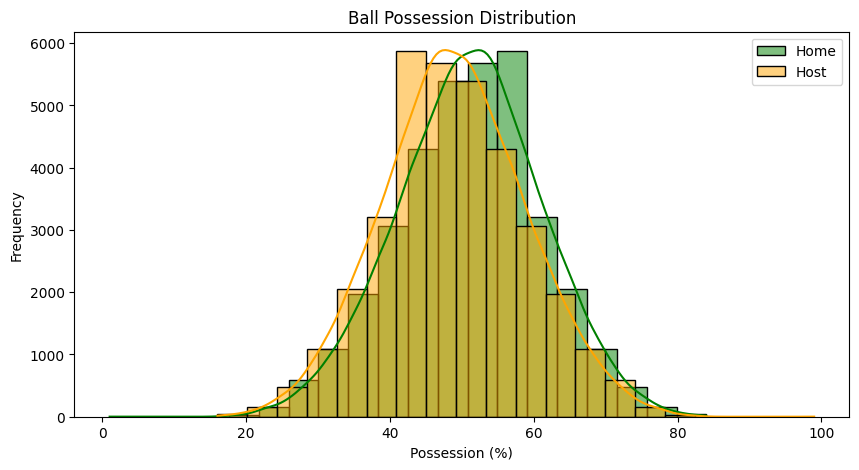

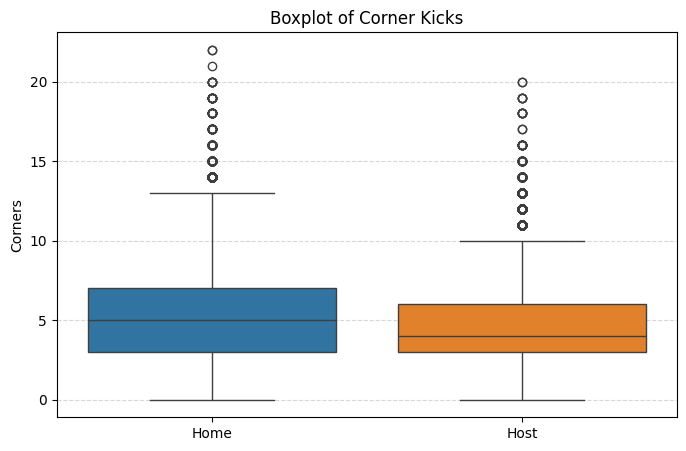

<ipython-input-20-45ada1ec0eee>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SecondHalfControl', data=df_model, palette='pastel')


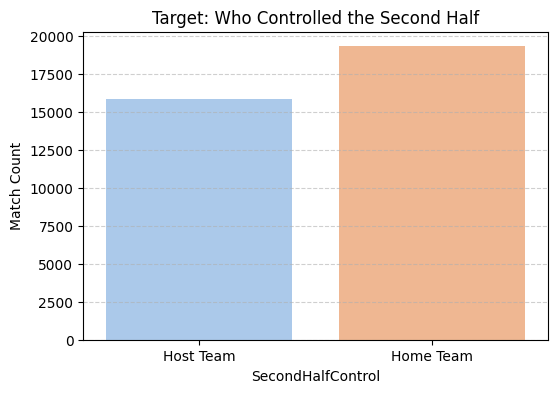

In [20]:
# Shots
plt.figure(figsize=(10, 5))
sns.histplot(df_model['Shots_on_Goal_Home'], color='blue', label='Home', kde=True, bins=20)
sns.histplot(df_model['Shots_on_Goal_Host'], color='red', label='Host', kde=True, bins=20)
plt.title('Distribution of Shots on Goal')
plt.xlabel('Shots')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Possession
plt.figure(figsize=(10, 5))
sns.histplot(df_model['Ball_Possession_Home'], color='green', label='Home', kde=True, bins=20)
sns.histplot(df_model['Ball_Possession_Host'], color='orange', label='Host', kde=True, bins=20)
plt.title('Ball Possession Distribution')
plt.xlabel('Possession (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Corners
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_model[['Corner_Kicks_Home', 'Corner_Kicks_Host']])
plt.title('Boxplot of Corner Kicks')
plt.ylabel('Corners')
plt.xticks([0, 1], ['Home', 'Host'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SecondHalfControl', data=df_model, palette='pastel')
plt.title('Target: Who Controlled the Second Half')
plt.xticks([0, 1], ['Host Team', 'Home Team'])
plt.ylabel('Match Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


**Train the AI model**

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

**Evaluate the model**

Precision: 0.9947173798203909
Recall: 0.9863803038239917
F1-score: 0.9905312993161494
Accuracy: 0.9897770836291353


<ipython-input-22-63e9eef0bdf3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


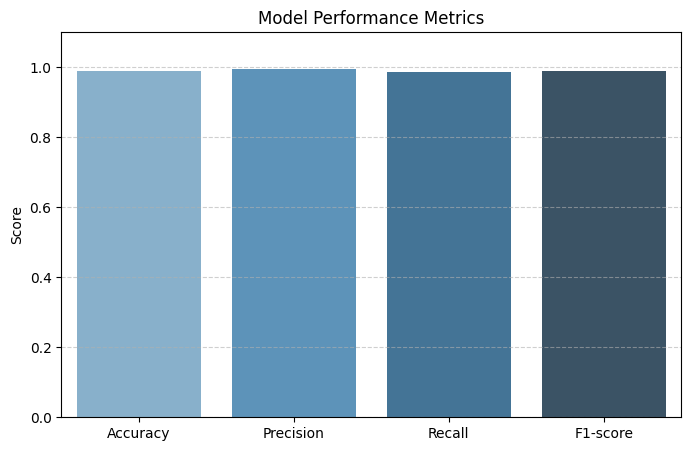


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3225
           1       0.99      0.99      0.99      3818

    accuracy                           0.99      7043
   macro avg       0.99      0.99      0.99      7043
weighted avg       0.99      0.99      0.99      7043



In [22]:
# Visualize model performance metrics

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=scores, palette='Blues_d')
plt.ylim(0, 1.1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

**Interactive prediction demo**

In [23]:
def show_prediction(index):
    clear_output(wait=True)
    if index >= len(X):
        print("Index out of range!")
        return
    sample_input = X.iloc[[index]]
    sample_row = sample_input.iloc[0]
    prediction = model.predict(sample_input)[0]
    result = "✅ Home team will likely control the 2nd half" if prediction == 1 else "✅ Host team will likely control the 2nd half"
    print(f"Match #{index} - First Half Stats")
    display(sample_input)
    print("AI Prediction:", result)

    labels = ['Shots', 'Possession', 'Fouls', 'Corners', 'Score']
    home_values = [
        sample_row['Shots_on_Goal_Home'],
        sample_row['Ball_Possession_Home'],
        sample_row['Fouls_Home'],
        sample_row['Corner_Kicks_Home'],
        sample_row['home_score']
    ]
    host_values = [
        sample_row['Shots_on_Goal_Host'],
        sample_row['Ball_Possession_Host'],
        sample_row['Fouls_Host'],
        sample_row['Corner_Kicks_Host'],
        sample_row['away_score']
    ]

    x = range(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, home_values, width=0.35, label='Home', align='center')
    plt.bar([p + 0.35 for p in x], host_values, width=0.35, label='Host', align='center')
    plt.xticks([p + 0.175 for p in x], labels)
    plt.title('First Half Comparison')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

slider = widgets.IntSlider(value=0, min=0, max=len(X)-1, step=1, description='Match:')
widgets.interact(show_prediction, index=slider);


interactive(children=(IntSlider(value=0, description='Match:', max=35214), Output()), _dom_classes=('widget-in…